## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import pickle
import time
import re

## Loading the data

In [24]:
train_set = pd.read_csv(r'E:\Work Space\Ecko data\text_classification\Corona_NLP_train.csv', encoding="latin1")
test_set = pd.read_csv(r'E:\Work Space\Ecko data\text_classification\Corona_NLP_test.csv', encoding="latin1")
train_set.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Data Overview
#### Dropping unrelevant features

In [25]:
unrelevant_features = ["UserName", "ScreenName", "Location", "TweetAt"]

train_set.drop(unrelevant_features,inplace=True,axis=1)
test_set.drop(unrelevant_features,inplace=True,axis=1)
train_set.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


## Split sentences as their class, Positive,Neutral and Negative

In [26]:
train_set["Sentiment"].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [27]:
positives = train_set[(train_set["Sentiment"] == "Positive") | (train_set["Sentiment"] == "Extremely Positive")]
positives_test = test_set[(test_set["Sentiment"] == "Positive") | (test_set["Sentiment"] == "Extremely Positive")]
print(positives["Sentiment"].value_counts())
positives.head()

Positive              11422
Extremely Positive     6624
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
5,As news of the regionÂs first confirmed COVID...,Positive
6,Cashier at grocery store was sharing his insig...,Positive


In [28]:
negatives = train_set[(train_set["Sentiment"] == "Negative") | (train_set["Sentiment"] == "Extremely Negative")]
negatives_test = test_set[(test_set["Sentiment"] == "Negative") | (test_set["Sentiment"] == "Extremely Negative")]
print(negatives["Sentiment"].value_counts())
negatives.head()

Negative              9917
Extremely Negative    5481
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
9,"For corona prevention,we should stop to buy th...",Negative
20,with 100 nations inficted with covid 19 th...,Extremely Negative
24,@10DowningStreet @grantshapps what is being do...,Negative
26,In preparation for higher demand and a potenti...,Negative


In [29]:
neutrals = train_set[train_set["Sentiment"] == "Neutral"]
neutrals_test = test_set[test_set["Sentiment"] == "Neutral"]
print(neutrals["Sentiment"].value_counts())
neutrals.head()

Neutral    7713
Name: Sentiment, dtype: int64


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
7,Was at the supermarket today. Didn't buy toile...,Neutral
10,All month there hasn't been crowding in the su...,Neutral
16,????? ????? ????? ????? ??\r\r\n?????? ????? ?...,Neutral
17,@eyeonthearctic 16MAR20 Russia consumer survei...,Neutral


## Converting labels into integers 

In [30]:
import warnings as wrn
wrn.filterwarnings('ignore')

negatives["Sentiment"] = 0 
negatives_test["Sentiment"] = 0

positives["Sentiment"] = 2
positives_test["Sentiment"] = 2

neutrals["Sentiment"] = 1
neutrals_test["Sentiment"] = 1

negatives.head()

,OriginalTweet,Sentiment
4,"Me, ready to go at supermarket during the #COV...",0
9,"For corona prevention,we should stop to buy th...",0
20,with 100 nations inficted with covid 19 th...,0
24,@10DowningStreet @grantshapps what is being do...,0
26,In preparation for higher demand and a potenti...,0


## Concatenating train and test and will split them after processing

data = pd.concat([positives,
                  positives_test,
                  neutrals,
                  neutrals_test,
                  negatives,
                  negatives_test
                 ],axis=0)

data.reset_index(inplace=True)

In [31]:
data.head()

,index,OriginalTweet,Sentiment
0,1,advice Talk to your neighbours family to excha...,2
1,2,Coronavirus Australia: Woolworths to give elde...,2
2,3,My food stock is not the only one which is emp...,2
3,5,As news of the regionÂs first confirmed COVID...,2
4,6,Cashier at grocery store was sharing his insig...,2


#### Finally everything is ready, we can start examining data with examining random texts.

In [32]:
import random
for i in range(1,10):
    random_ind = random.randint(0,len(data))
    print(str(data["OriginalTweet"][random_ind]),end="\nLabel: ")
    print(str(data["Sentiment"][random_ind]),end="\n\n")

Whether you re working from home or staying entertained while you re probably relying on online shopping to stay supplied Our looks at what key categories shoppers are turning to these days
Label: 2



The billionaires will be picking over the spoils &amp; acquiring them at fire-sale prices.
Label: 0

@HillaryClinton There are no Covid-19 test kits at Salinas Valley Memorial Hospital! ThatÂs where many vegetables in your grocery store come from. Ag workers are in the fields for us. CanÂt we get testing for them?
Label: 0

The Pandemic Economy: What are Shoppers Buying Online During COVID-19? https://t.co/y9RMkNgle2 https://t.co/hy1qVDiNGw
Label: 1

A COVID-19 Cure for #Restaurants: Reaching Older Diners @FSRmag https://t.co/kdhenQjQjX @BlackBox_Intel #RestaurantNews @DKleinWriter https://t.co/O1n9wIOYAh
Label: 2

There have been chaotic scenes at some supermarkets with shoppers not heeding advice to avoid panic buying At one supermarket in the Black Country NHS workers who had been g

## Frequency distribution

In [33]:
positiveFD = nltk.FreqDist(word for text in data[data["Sentiment"] == 2]["OriginalTweet"] for word in text.lower().split())
negativeFD = nltk.FreqDist(word  for text in data[data["Sentiment"] == 0]["OriginalTweet"] for word in text.lower().split())
neutralDF = nltk.FreqDist(word  for text in data[data["Sentiment"] == 1]["OriginalTweet"] for word in text.lower().split())

## Most used words

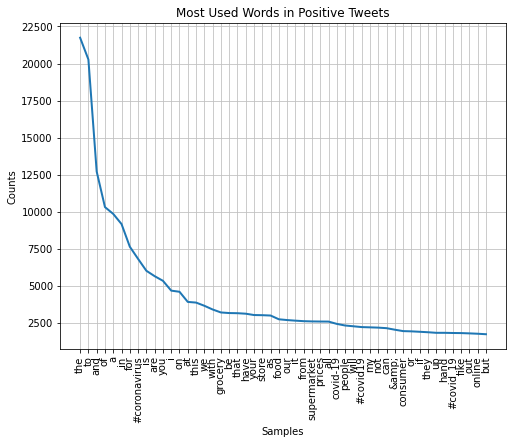

In [34]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

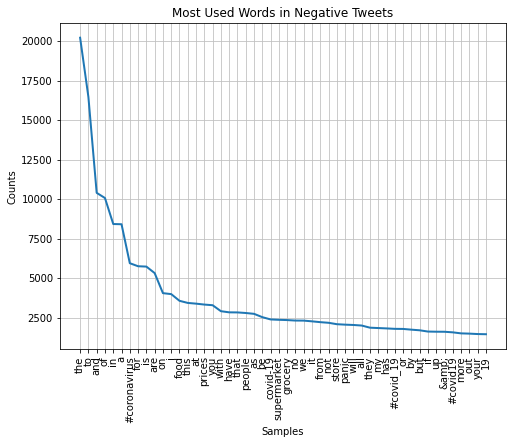

In [35]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

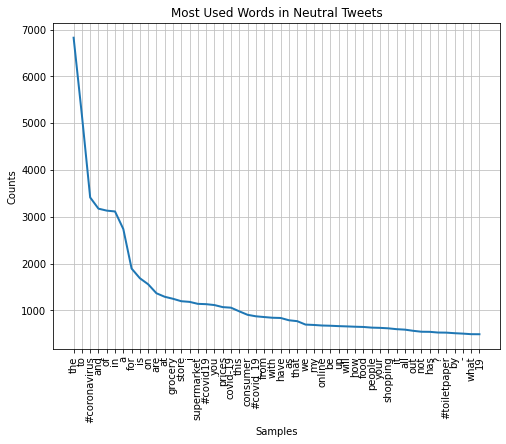

In [36]:
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Neutral Tweets")
neutralDF.plot(50)
plt.show()

## Data Preprocessing

In [37]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in data["OriginalTweet"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

In [38]:
for i in range(0,5):
    print(cleanedData[i],end="\n\n")

advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order

coronavirus australia woolworth give elderly disabled dedicated shopping hour amid covid 19 outbreak

food stock one empty please panic enough food everyone take need stay calm stay safe covid19france covid 19 covid19 coronavirus confinement confinementotal confinementgeneral

news region first confirmed covid 19 case came sullivan county last week people flocked area store purchase cleaning supply hand sanitizer food toilet paper good tim dodson report

cashier grocery store wa sharing insight covid 19 prove credibility commented civics class know talking



## Bag of words model

In [39]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(data["Sentiment"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33716, 10000)
(11239, 10000)
(33716,)
(11239,)


## Support Vector Machine Classifier Modeling

In [41]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

Fitting SVC took 1078.24 seconds


In [42]:
predictions = model.predict(x_test)

In [43]:
from sklearn.metrics import accuracy_score,confusion_matrix

print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))

Accuracy of model is 76.53705845715811%
